In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from imblearn.over_sampling import RandomOverSampler
from transformers import pipeline

In [22]:
# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("comments.csv")   # dataset (expects "Comments" column)
df = df.dropna(subset=["Comments"])  # drop empty rows

print("Sample data:\n", df.head())

Sample data:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


In [23]:
# ==============================
# 2. Generate Pseudo-Labels with Reliability Filtering
# ==============================
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def get_sentiment_with_score(text):
    try:
        r = sentiment_model(str(text))[0]
        return r['label'].lower(), r['score']
    except:
        return "neutral", 0.0

tmp = df['Comments'].apply(
    lambda t: pd.Series(get_sentiment_with_score(t), index=['Sentiment','Score'])
)
df = pd.concat([df, tmp], axis=1)

# Keep only positive/negative with confidence >= 0.6
df = df[(df["Sentiment"].isin(["positive", "negative"])) & (df["Score"] >= 0.6)]

print("\nSentiment distribution after filtering:\n", df["Sentiment"].value_counts())

Device set to use mps:0



Sentiment distribution after filtering:
 Sentiment
negative    801
positive    160
Name: count, dtype: int64


In [24]:
# ==============================
# 3. Train-Test-Unseen Split (70/20/10)
# ==============================
# Step 1: Hold out 10% unseen
rest_df, unseen_df = train_test_split(
    df, test_size=0.10, stratify=df['Sentiment'], random_state=42
)
# Step 2: From remaining 90%, split 70/20 (relative: 70/90 ≈ 77.8%)
train_df, test_df = train_test_split(
    rest_df, test_size=2/9, stratify=rest_df['Sentiment'], random_state=42
)

print(f"\nTrain: {len(train_df)}, Test: {len(test_df)}, Unseen: {len(unseen_df)}")


Train: 672, Test: 192, Unseen: 97


In [25]:
# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Comments'])
y_train = train_df['Sentiment']
X_test = vectorizer.transform(test_df['Comments'])
y_test = test_df['Sentiment']
X_unseen = vectorizer.transform(unseen_df['Comments'])
y_unseen = unseen_df['Sentiment']

In [26]:
# ==============================
# 5. Apply RandomOverSampler (fixes SMOTE issue with sparse)
# ==============================
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("\nBalanced training distribution:\n", pd.Series(y_train_bal).value_counts())


Balanced training distribution:
 Sentiment
negative    560
positive    560
Name: count, dtype: int64



===== Naive Bayes =====
Accuracy (Test): 0.7083
              precision    recall  f1-score   support

    negative       0.86      0.78      0.82       160
    positive       0.25      0.38      0.30        32

    accuracy                           0.71       192
   macro avg       0.56      0.57      0.56       192
weighted avg       0.76      0.71      0.73       192



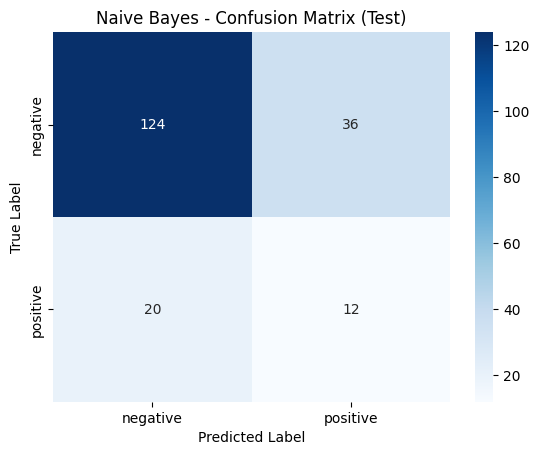


===== Logistic Regression =====
Accuracy (Test): 0.7552
              precision    recall  f1-score   support

    negative       0.85      0.86      0.85       160
    positive       0.24      0.22      0.23        32

    accuracy                           0.76       192
   macro avg       0.54      0.54      0.54       192
weighted avg       0.75      0.76      0.75       192



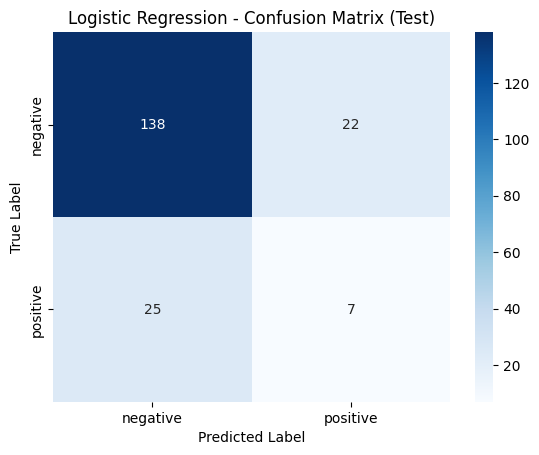


Best Logistic Regression params: {'C': 10}


In [27]:
# ==============================
# 6. Train Models (with Iterative Improvement for LR)
# ==============================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy (Test): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {"model": model, "test_acc": acc}

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Iterative Improvement: Hyperparameter tuning for Logistic Regression
param_grid = {"C": [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid, cv=3, scoring="f1_macro"
)
grid.fit(X_train_bal, y_train_bal)
print("\nBest Logistic Regression params:", grid.best_params_)
best_lr = grid.best_estimator_

# Update results with best LR
results["Logistic Regression (Tuned)"] = {
    "model": best_lr,
    "test_acc": accuracy_score(y_test, best_lr.predict(X_test))
}


===== Final Evaluation on Unseen Data (Naive Bayes) =====
Accuracy (Unseen): 0.7732
              precision    recall  f1-score   support

    negative       0.90      0.81      0.86        81
    positive       0.38      0.56      0.45        16

    accuracy                           0.77        97
   macro avg       0.64      0.69      0.65        97
weighted avg       0.82      0.77      0.79        97



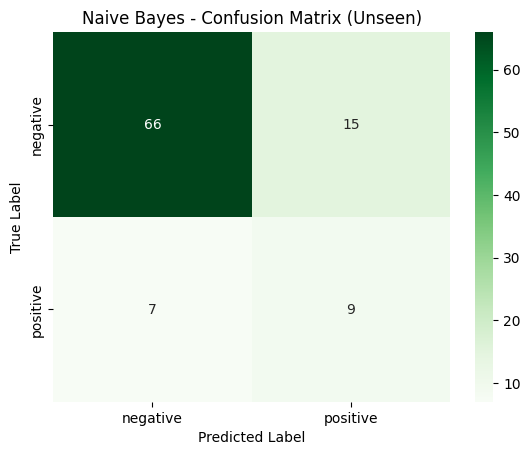


===== Final Evaluation on Unseen Data (Logistic Regression) =====
Accuracy (Unseen): 0.7835
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87        81
    positive       0.33      0.31      0.32        16

    accuracy                           0.78        97
   macro avg       0.60      0.59      0.60        97
weighted avg       0.78      0.78      0.78        97



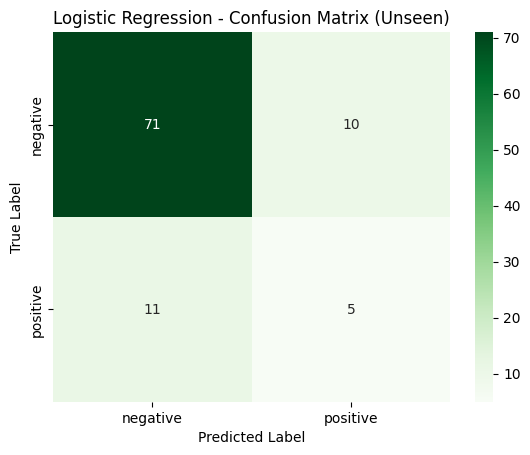


===== Final Evaluation on Unseen Data (Logistic Regression (Tuned)) =====
Accuracy (Unseen): 0.8144
              precision    recall  f1-score   support

    negative       0.86      0.93      0.89        81
    positive       0.40      0.25      0.31        16

    accuracy                           0.81        97
   macro avg       0.63      0.59      0.60        97
weighted avg       0.79      0.81      0.80        97



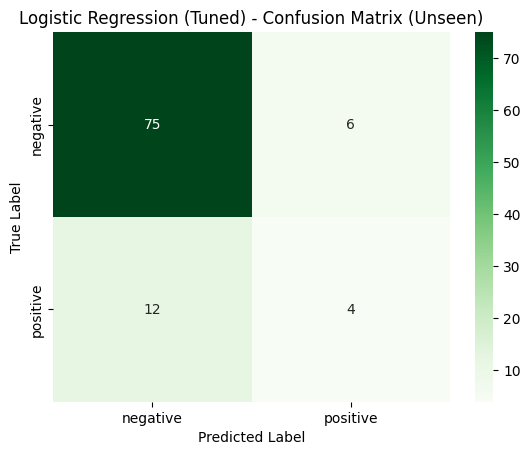

In [28]:
# ==============================
# 7. Evaluate on Unseen Data
# ==============================
for name, res in results.items():
    print(f"\n===== Final Evaluation on Unseen Data ({name}) =====")
    model = res["model"]
    y_pred_unseen = model.predict(X_unseen)
    acc_unseen = accuracy_score(y_unseen, y_pred_unseen)
    print(f"Accuracy (Unseen): {acc_unseen:.4f}")
    print(classification_report(y_unseen, y_pred_unseen))

    cm = confusion_matrix(y_unseen, y_pred_unseen, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Unseen)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [29]:
# ==============================
# 9. Additional Analysis
# ==============================
print("\n===== ADDITIONAL ANALYSIS =====")
for name, res in results.items():
    model = res['model']
    y_pred = model.predict(X_test)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='positive')
    print(f"{name} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")

# Error analysis: show sample false positives/negatives
best_model = results["Logistic Regression (Tuned)"]["model"]
test_df = test_df.copy()
test_df["Pred"] = best_model.predict(X_test)
fn = test_df[(test_df['Sentiment']=='positive') & (test_df['Pred']=='negative')].head(5)
fp = test_df[(test_df['Sentiment']=='negative') & (test_df['Pred']=='positive')].head(5)

print("\nSAMPLE FALSE NEGATIVES:\n", fn['Comments'].tolist())
print("\nSAMPLE FALSE POSITIVES:\n", fp['Comments'].tolist())


===== ADDITIONAL ANALYSIS =====
Naive Bayes -> Precision: 0.250, Recall: 0.375, F1: 0.300
Logistic Regression -> Precision: 0.241, Recall: 0.219, F1: 0.230
Logistic Regression (Tuned) -> Precision: 0.150, Recall: 0.094, F1: 0.115

SAMPLE FALSE NEGATIVES:
 ['Ang daming perang nasasayang.', 'Malamang completed ang phase 1. May phase 2 3 4 5 6 7 pa yan. More phase. More kickbacks', "Ang sinungaling at ang magnanakaw ay kapatid ng kadiliman at kasamaan!\n\nFloods were getting everywhere amid climate crisis, not just the Philippines but the whole world itself. We Filipinos believe in our minds and our intelligence that this 51 billion budget for Davao City, Davao del Sur's flood control infrastructure was stolen and snatched by the Dutertes used for political gains, personal agendas and vicious Duterteism ideology that is anti-Filipino, anti-humanity and anti-democratic.", 'Maraming Salamat SK President Lee for halting the P28.7B loan to Pinas as “Potential for Corruption”. More money for 

In [30]:
# ==============================
# 8. Top Positive & Negative Comments (Top 10 each)
# ==============================

# Use the tuned Logistic Regression model
best_model = results["Logistic Regression (Tuned)"]["model"]

# Get prediction probabilities for unseen data
probs = best_model.predict_proba(X_unseen)
unseen_df = unseen_df.copy()
unseen_df["Negative Probability"] = probs[:, 0].round(3)
unseen_df["Positive Probability"] = probs[:, 1].round(3)

# Select top 10 rows for each sentiment
top_neg_display = (
    unseen_df.sort_values("Negative Probability", ascending=False)
    .loc[:, ["Comments", "Negative Probability"]]
    .head(10)
    .reset_index(drop=True)
)
top_pos_display = (
    unseen_df.sort_values("Positive Probability", ascending=False)
    .loc[:, ["Comments", "Positive Probability"]]
    .head(10)
    .reset_index(drop=True)
)

# Reset table indices to start from 1
top_neg_display.index += 1
top_pos_display.index += 1

# ==============================
# Display styled tables
# ==============================
print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE COMMENTS")
print("="*80)
display(
    top_neg_display.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#ffcccc'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
    ])
)

print("\n" + "="*80)
print("TOP 10 MOST POSITIVE COMMENTS")
print("="*80)
display(
    top_pos_display.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#ccffcc'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
    ])
)


TOP 10 MOST NEGATIVE COMMENTS


,Comments,Negative Probability
1,"Tanga nga kase yung bengbeng. Hanggang tree planting lang yung understanding. Bago pa magkaugat yung puno naanod na ng baha at naitangay na ng bagyo. Asa ka sa tamad na yan, eh nakatira yan sa mansyon. Wala ba syang magaling na advisor?",0.998000
2,Simulan sa pagtatakwil sa sariling USTE alumnus na si Joel Villanueva. Wag na panuorin ng UAAP yan baka ma boo lng.,0.997000
3,bakit po si discaya lang ginigisa sa senado wala ung mga Co?,0.997000
4,Nasaan na meow meow nyo? 🤣🤣😂🤪😁,0.992000
5,si sylvia sanchez ngayon ka magpa interbyu at sagutin mo yan,0.992000
6,"Not a lawyer here, but genuinely curious. Pag ganyan ba hindi pwedeng habulin yung company? Di man mapanagot yung tao kasi wala na, maybe we can cripple their construction firms -- makaganti man lang tayo",0.991000
7,"2023 palang inoopen na ni Sen Joel Villanueva yan wala lang nakikinig, kung hindi pa bumagyo at bumaha hindi papansinin yan",0.990000
8,Kaya nakakaduda yung binigay nilang (Discaya) pangalan sa listahan.,0.986000
9,matagal ng may gumagawa ng ganyan sa ibat ibang lugar ngayon lang talaga nagkaka lagutan dami ng nag palitan ng posisyon ngayon lang talaga 🥴,0.982000
10,"Malawakang Plunder ang ginawa ng mga hyop na yan. Pag walang makulong dyan ng life sentence, galit galit na tayo Mr. BBM.",0.978000



TOP 10 MOST POSITIVE COMMENTS


,Comments,Positive Probability
1,Nice to meet you again!,0.941000
2,Actions speak louder than words…,0.852000
3,Hope that the crowd is led by the right people or our nation falls into more division and distraction to more fundamental issue involving national security amid rising tension bet. US and China where Philippines is the prime target being a US military satellite.,0.827000
4,Firing squad for them is meritorious,0.775000
5,Future millionaires liked this comment,0.755000
6,"Madam jess my 35 yesrs stint wit coa was not all joys , , mostly hhesrtaches but thanks the good lord hzd guided me along the way , ,its always an uphill journey to the ombudsman and sandigan bzyan esp when your immediate boss is your silent enemy protecting the various accountable ofgicer",0.716000
7,Nice louder,0.702000
8,Tapos sa huli walang makukulong 🤦🏻‍♀️🤦🏻‍♀️🤦🏻‍♀️,0.612000
9,I hope and pray that Mayor Vico would be the next president 2028,0.597000
10,"pano nakalusot sa mayors office, coa, dpwh? nakakapagtaka haha",0.538000
